In [ ]:
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from landlab.components import PriorityFloodFlowRouter
from landlab.components import ErosionDeposition, FlowAccumulator
from landlab.plot import imshow_grid
ot as plt
import numpy as np
from matplotlib import cm

from landlab import HexModelGrid, RasterModelGrid
from landlab.components import (
    DepressionFinderAndRouter,
    FlowAccumulator,
    FlowDirectorD8,
    FlowDirectorSteepest,
)
from landlab.plot.drainage_plot import drainage_plot


dx = 100.0
K = 0.0001  # erodibility coefficient, 1/yr
m_sp = 0.5  # exponent on drainage area or discharge, -
n_sp = 1.0  # exponent on slope, -
sp_crit = 0.0  # erosion threshold
v_s = 100.0  # settling velocity parameter (dimensionless if drainage area is used instead of discharge)
F_f = 0.5  # fraction of fines generated during bed erosion
initial_elevation = (
    200.0  # starting elevation of an "uplifted block" (rapid baselevel drop), m
)

run_duration = 1200.0  # duration of run, yr
dt = 10.0  # time-step duration, yr
plot_every = 200.0  # time interval for plotting, yr

# Derived parameters
nsteps = int(run_duration / dt)
next_plot = plot_every

# set up colormap
cmap = copy.copy(mpl.colormaps["pink"])

#fa = PriorityFlodFlowRouter(rmg)

# this is the same as writing:
fa = PriorityFloodFlowRouter(
    rmg,
    surface="topographic__elevation",
    flow_metric="D8",
    update_flow_depressions=True,
    runoff_rate=None,
    depression_handler="breach",
)
fa.run_one_step()

#plt.figure()
#drainage_plot(rmg)

#fr = FlowAccumulator(rmg, depression_finder="DepressionFinderAndRouter")
ed = ErosionDeposition(
    rmg,
    K=K,
    m_sp=m_sp,
    n_sp=n_sp,
    sp_crit=sp_crit,
    v_s=v_s,
    F_f=F_f,
    solver="adaptive",  # use the adaptive time stepper, which is slightly faster
)
for i in range(1, nsteps + 1):
    # route flow
    fa.run_one_step()  # run_one_step isn't time sensitive, so it doesn't take dt as input

    # do some erosion/deposition
    ed.run_one_step(dt)

    if i * dt >= next_plot:
        plt.figure()
        imshow_grid(
            rmg,
            "topographic__elevation",
            grid_units=["m", "m"],
            var_name="Elevation (m)",
            cmap=cmap,
        )
        next_plot += plot_every

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from landlab import RasterModelGrid
from landlab.components import (
    PriorityFloodFlowRouter,
    ErosionDeposition,
)
from landlab.plot import imshow_grid, drainage_plot

# --- Parameters ---
dx = 100.0
K = 0.0001
m_sp = 0.5
n_sp = 1.0
sp_crit = 0.0
v_s = 100.0
F_f = 0.5
initial_elevation = 200.0

run_duration = 1200.0
dt = 10.0
plot_every = 200.0

nrows = ncols = 41
nsteps = int(run_duration / dt)
next_plot = plot_every

# --- Create grid and set elevation ---
rmg = RasterModelGrid((nrows, ncols), dx)
z = rmg.add_zeros("topographic__elevation", at="node")
rmg.add_zeros("bedrock__elevation", at="node")
z[:] = initial_elevation + np.random.rand(len(z)) / 1000.0  # slight noise

# --- Set up flow routing and erosion components ---
fa = PriorityFloodFlowRouter(
    rmg,
    surface="topographic__elevation",
    flow_metric="D8",
    update_flow_depressions=True,
    depression_handler="breach",
)
ed = ErosionDeposition(
    rmg,
    K=K,
    m_sp=m_sp,
    n_sp=n_sp,
    sp_crit=sp_crit,
    v_s=v_s,
    F_f=F_f,
    solver="adaptive",
)

# --- Colormap ---
cmap = mpl.colormaps["pink"]

# --- Plot helper ---
def plot_topography(title, step):
    plt.figure()
    imshow_grid(
        rmg,
        "topographic__elevation",
        var_name="Elevation (m)",
        grid_units=["m", "m"],
        cmap=cmap,
    )
    plt.title(f"{title} at Year {step}")
    plt.tight_layout()
    plt.savefig(f"topography_year_{step}.png")
    plt.close()

# --- Initial drainage plot ---
#plt.figure()
#drainage_plot(rmg)
plt.title("Initial Drainage")
plt.savefig("initial_drainage.png")
plt.close()

# --- Initial topography ---
plot_topography("Initial Topography", step=0)

# --- Run model ---
for i in range(1, nsteps + 1):
    fa.run_one_step()
    ed.run_one_step(dt)

    current_time = i * dt
    if current_time >= next_plot:
        plot_topography("Topography", step=int(current_time))
        next_plot += plot_every


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshow_grid
from landlab.io import read_esri_ascii
from landlab.components import PriorityFloodFlowRouter, SpaceLargeScaleEroder
from tqdm import tqdm
import os

# --- Load grid and elevation ---
rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
rmg.status_at_node[z < 0.0] = rmg.BC_NODE_IS_CLOSED

# --- Set a fixed outlet node (e.g., bottom center) ---
bottom_nodes = rmg.nodes_at_bottom_edge
center_bottom = bottom_nodes[len(bottom_nodes) // 2]
rmg.status_at_node[center_bottom] = rmg.BC_NODE_IS_FIXED_VALUE

# --- Initialize soil depth and add to elevation ---
soil_depth = 0.3
s = rmg.add_zeros("soil__depth", at="node")
s += soil_depth
z += s  # Add soil depth to surface elevation

# --- Initialize erosion model components ---
fr = PriorityFloodFlowRouter(rmg, flow_metric="D8", update_flow_depressions=True)
ha = SpaceLargeScaleEroder(
    rmg, K_sed=0.0001, K_br=0.0001, phi=0.3, H_star=1.0
)

br = rmg.at_node["bedrock__elevation"]
z = rmg.at_node["topographic__elevation"]

# --- Save initial topography plot ---
plt.figure()
imshow_grid(rmg, "topographic__elevation", cmap="terrain")
plt.title("Initial Topography")
plt.savefig("initial_topography.png", dpi=300)
plt.close()

# --- Run model over time ---
space_dt = 100
n_steps = 250

for _ in tqdm(range(n_steps), desc="Running landscape evolution"):
    br[rmg.core_nodes] += 0.001 * space_dt  # uniform uplift
    z[rmg.core_nodes] = br[rmg.core_nodes] + s[rmg.core_nodes]
    fr.run_one_step()
    ha.run_one_step(dt=space_dt)

# --- Save final topography plot ---
plt.figure()
imshow_grid(rmg, "topographic__elevation", cmap="terrain")
plt.title("Final Topography")
plt.savefig("final_topography.png", dpi=300)
plt.close()

print("Simulation complete. Plots saved as 'initial_topography.png' and 'final_topography.png'.")


/tmp/ipykernel_746474/2620184515.py:10: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
Running landscape evolution: 100%|██████████| 250/250 [00:08<00:00, 30.92it/s]


Simulation complete. Plots saved as 'initial_topography.png' and 'final_topography.png'.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshow_grid
from landlab.io import read_esri_ascii
from landlab.components import PriorityFloodFlowRouter, SpaceLargeScaleEroder
import os

# --- Load grid and elevation ---
rmg_orig, z_orig = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
z_orig[z_orig < 0.0] = np.nan  # mask invalid elevations

# --- Directory to save outputs ---
output_dir = "m_sp_results"
os.makedirs(output_dir, exist_ok=True)

# --- Loop over m_sp values ---
m_sp_values = np.arange(0.0, 1.01, 0.2)

for m_val in m_sp_values:
    # Create a fresh grid copy for each m_sp
    rmg = RasterModelGrid(rmg_orig.shape, xy_spacing=rmg_orig.dx)
    rmg.add_field("topographic__elevation", z_orig.copy(), at="node")
    rmg.status_at_node[z_orig < 0.0] = rmg.BC_NODE_IS_CLOSED

    # Define outlet (e.g., bottom center node)
    bottom_nodes = rmg.nodes_at_bottom_edge
    center_bottom = bottom_nodes[len(bottom_nodes) // 2]
    rmg.status_at_node[center_bottom] = rmg.BC_NODE_IS_FIXED_VALUE

    # Add soil depth
    s = rmg.add_zeros("soil__depth", at="node")
    s += 0.3
    rmg.at_node["topographic__elevation"] += s

    # Initialize components
    fr = PriorityFloodFlowRouter(rmg, flow_metric="D8", update_flow_depressions=True)
    ha = SpaceLargeScaleEroder(
        rmg,
        K_sed=0.0001,
        K_br=0.0001,
        phi=0.3,
        H_star=1.0,
        m_sp=m_val,
        n_sp=1.0
    )

    br = rmg.at_node["bedrock__elevation"]
    z = rmg.at_node["topographic__elevation"]

    # --- Run for 1 year (single timestep) ---
    space_dt = 100  # duration of a single timestep
    br[rmg.core_nodes] += 0.001 * space_dt  # uplift
    z[rmg.core_nodes] = br[rmg.core_nodes] + s[rmg.core_nodes]
    fr.run_one_step()
    ha.run_one_step(dt=space_dt)

    # --- Plot and save ---
    plt.figure()
    imshow_grid(rmg, "topographic__elevation", cmap="terrain")
    plt.title(f"Topography after 1 year (m_sp={m_val:.1f})")
    plt.savefig(f"{output_dir}/topography_msp_{m_val:.1f}.png", dpi=300)
    plt.close()

print(f"All plots saved in '{output_dir}' folder.")


/tmp/ipykernel_746474/3599583062.py:9: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rmg_orig, z_orig = read_esri_ascii("hugo_site.asc", name="topographic__elevation")


All plots saved in 'm_sp_results' folder.


/tmp/ipykernel_746474/1487882337.py:11: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rmg_orig, z_orig = read_esri_ascii("hugo_site.asc", name="topographic__elevation")


TypeError: _imshow_grid_values() got an unexpected keyword argument 'ax'

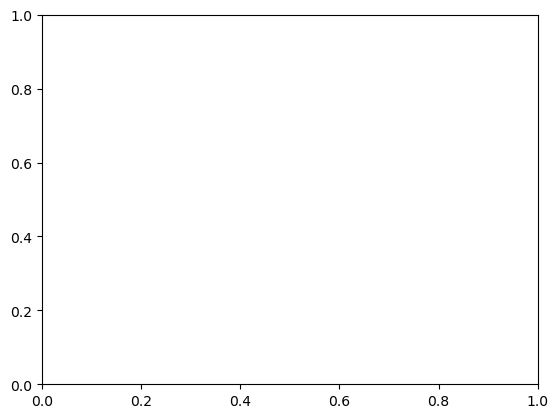

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from landlab import RasterModelGrid, imshow_grid
from landlab.io import read_esri_ascii
from landlab.components import PriorityFloodFlowRouter, SpaceLargeScaleEroder
from PIL import Image

# --- Load grid and elevation ---
rmg_orig, z_orig = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
z_orig[z_orig < 0.0] = np.nan  # mask invalid elevations

# --- Output directory ---
output_dir = "m_sp_results"
os.makedirs(output_dir, exist_ok=True)

# --- Varying m_sp values ---
m_sp_values = np.arange(0.0, 1.01, 0.2)

for m_val in m_sp_values:
    # Copy grid and elevation for each run
    rmg = RasterModelGrid(rmg_orig.shape, xy_spacing=rmg_orig.dx)
    rmg.add_field("topographic__elevation", z_orig.copy(), at="node")
    rmg.status_at_node[z_orig < 0.0] = rmg.BC_NODE_IS_CLOSED

    # Set outlet
    center_bottom = rmg.nodes_at_bottom_edge[len(rmg.nodes_at_bottom_edge) // 2]
    rmg.status_at_node[center_bottom] = rmg.BC_NODE_IS_FIXED_VALUE

    # Add soil depth
    s = rmg.add_zeros("soil__depth", at="node")
    s += 0.3
    rmg.at_node["topographic__elevation"] += s

    # Initialize components
    fr = PriorityFloodFlowRouter(rmg, flow_metric="D8", update_flow_depressions=True)
    ha = SpaceLargeScaleEroder(
        rmg,
        K_sed=0.0001,
        K_br=0.0001,
        phi=0.3,
        H_star=1.0,
        m_sp=m_val,
        n_sp=1.0
    )

    # Get fields
    br = rmg.at_node["bedrock__elevation"]
    z = rmg.at_node["topographic__elevation"]

    # Run for 1 year
    space_dt = 100
    br[rmg.core_nodes] += 0.001 * space_dt
    z[rmg.core_nodes] = br[rmg.core_nodes] + s[rmg.core_nodes]
    fr.run_one_step()
    ha.run_one_step(dt=space_dt)

    # Save CSV
    elevation_2d = z.reshape(rmg.shape)
    csv_path = f"{output_dir}/elevation_msp_{m_val:.1f}.csv"
    pd.DataFrame(elevation_2d).to_csv(csv_path, index=False, header=False)

    # Save and show plot
    fig, ax = plt.subplots()
    imshow_grid(rmg, "topographic__elevation", cmap="terrain", ax=ax)
    ax.set_title(f"Topography (m_sp={m_val:.1f})")
    fig_path = f"{output_dir}/topography_msp_{m_val:.1f}.png"
    plt.savefig(fig_path, dpi=300)
    plt.close()

    # Display saved image
    img = Image.open(fig_path)
    img.show()

print("All elevation CSVs and plots saved and displayed.")


/tmp/ipykernel_746474/2503056570.py:11: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rmg_orig, z_orig = read_esri_ascii("hugo_site.asc", name="topographic__elevation")


TypeError: _imshow_grid_values() got an unexpected keyword argument 'ax'

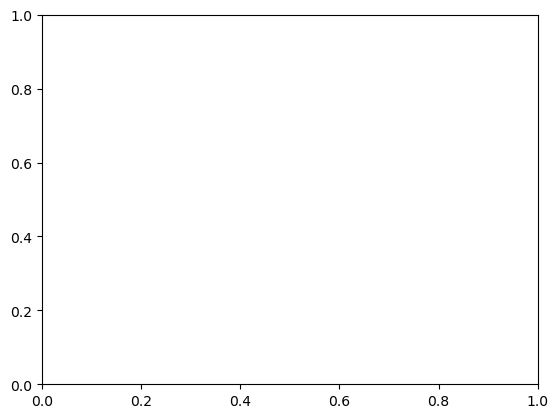

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from landlab import RasterModelGrid, imshow_grid
from landlab.io import read_esri_ascii
from landlab.components import PriorityFloodFlowRouter, SpaceLargeScaleEroder
from PIL import Image

# --- Load grid and elevation ---
rmg_orig, z_orig = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
z_orig[z_orig < 0.0] = np.nan  # mask invalid elevations

# --- Output directory ---
output_dir = "m_sp_results"
os.makedirs(output_dir, exist_ok=True)

# --- Create master CSV storage ---
all_data = []

# --- Varying m_sp values ---
m_sp_values = np.arange(0.0, 1.01, 0.2)

for m_val in m_sp_values:
    # Copy grid and elevation for each run
    rmg = RasterModelGrid(rmg_orig.shape, xy_spacing=rmg_orig.dx)
    rmg.add_field("topographic__elevation", z_orig.copy(), at="node")
    rmg.status_at_node[z_orig < 0.0] = rmg.BC_NODE_IS_CLOSED

    # Set outlet
    center_bottom = rmg.nodes_at_bottom_edge[len(rmg.nodes_at_bottom_edge) // 2]
    rmg.status_at_node[center_bottom] = rmg.BC_NODE_IS_FIXED_VALUE

    # Add soil depth
    s = rmg.add_zeros("soil__depth", at="node")
    s += 0.3
    rmg.at_node["topographic__elevation"] += s

    # Initialize components
    fr = PriorityFloodFlowRouter(rmg, flow_metric="D8", update_flow_depressions=True)
    ha = SpaceLargeScaleEroder(
        rmg,
        K_sed=0.0001,
        K_br=0.0001,
        phi=0.3,
        H_star=1.0,
        m_sp=m_val,
        n_sp=1.0
    )

    # Get fields
    br = rmg.at_node["bedrock__elevation"]
    z = rmg.at_node["topographic__elevation"]

    # Run for 1 year (1 step)
    space_dt = 100
    br[rmg.core_nodes] += 0.001 * space_dt
    z[rmg.core_nodes] = br[rmg.core_nodes] + s[rmg.core_nodes]
    fr.run_one_step()
    ha.run_one_step(dt=space_dt)

    # Save results to master list
    df = pd.DataFrame({
        "x": rmg.node_x,
        "y": rmg.node_y,
        "elevation": z,
        "m_sp": m_val
    })
    all_data.append(df)

    # Save and show plot
    fig, ax = plt.subplots()
    imshow_grid(rmg, "topographic__elevation", cmap="terrain", ax=ax)
    ax.set_title(f"Topography (m_sp={m_val:.1f})")
    fig_path = f"{output_dir}/topography_msp_{m_val:.1f}.png"
    plt.savefig(fig_path, dpi=300)
    plt.close()

    # Show image
    img = Image.open(fig_path)
    img.show()

# --- Save all steps to one CSV ---
final_df = pd.concat(all_data, ignore_index=True)
final_df.to_csv(f"{output_dir}/elevation_vs_msp.csv", index=False)

print(f"\nAll results saved to '{output_dir}/elevation_vs_msp.csv' and plots generated.")


/tmp/ipykernel_746474/61759133.py:15: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rmg_init, z_init = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmp0ajpfhhd.PNG'


TypeError: _imshow_grid_values() got an unexpected keyword argument 'ax'

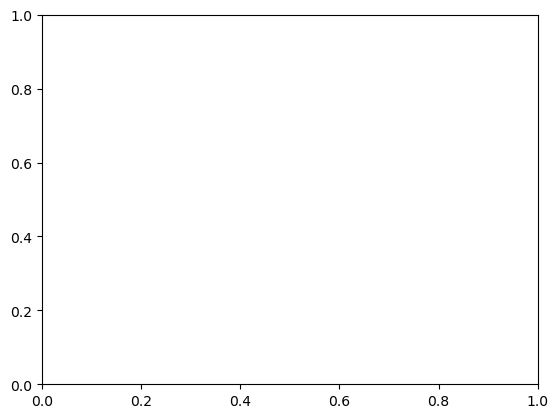

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshow_grid
from landlab.io import read_esri_ascii
from landlab.components import PriorityFloodFlowRouter, SpaceLargeScaleEroder
import os
from PIL import Image

# --- Configuration ---
output_dir = "m_sp_results"
os.makedirs(output_dir, exist_ok=True)

# --- Read input grid ---
rmg_init, z_init = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
z_init[z_init < 0.0] = np.nan
rmg_init.status_at_node[z_init < 0.0] = rmg_init.BC_NODE_IS_CLOSED

# --- Save initial grid to CSV ---
init_df = pd.DataFrame({
    "x": rmg_init.node_x,
    "y": rmg_init.node_y,
    "elevation": z_init,
})
init_df.to_csv(os.path.join(output_dir, "initial_topography.csv"), index=False)

# --- Plot and show initial topography ---
plt.figure()
imshow_grid(rmg_init, "topographic__elevation", cmap="terrain")
plt.title("Initial Topography")
initial_plot_path = os.path.join(output_dir, "initial_topography.png")
plt.savefig(initial_plot_path)
plt.close()

Image.open(initial_plot_path).show()

# --- Simulation parameters ---
space_dt = 100
soil_depth = 0.3
m_sp_values = np.arange(0.0, 1.01, 0.2)

# --- Run for each m_sp value ---
for m_sp_val in m_sp_values:
    # Fresh copy of grid
    rmg = RasterModelGrid(rmg_init.shape, xy_spacing=rmg_init.dx)
    z = z_init.copy()
    rmg.add_field("topographic__elevation", z, at="node")
    rmg.status_at_node[z < 0.0] = rmg.BC_NODE_IS_CLOSED

    # Set outlet node (middle of bottom edge)
    outlet = rmg.nodes_at_bottom_edge[len(rmg.nodes_at_bottom_edge) // 2]
    rmg.status_at_node[outlet] = rmg.BC_NODE_IS_FIXED_VALUE

    # Add soil depth and update elevation
    rmg.add_zeros("soil__depth", at="node")
    rmg.at_node["soil__depth"] += soil_depth
    rmg.at_node["topographic__elevation"] += rmg.at_node["soil__depth"]

    # Initialize models
    fr = PriorityFloodFlowRouter(rmg, flow_metric="D8", update_flow_depressions=True)
    ha = SpaceLargeScaleEroder(
        rmg,
        K_sed=0.0001,
        K_br=0.0001,
        phi=0.3,
        H_star=1.0,
        m_sp=m_sp_val,
        n_sp=1.0,
    )

    # Run for one timestep
    br = rmg.at_node["bedrock__elevation"]
    s = rmg.at_node["soil__depth"]
    z = rmg.at_node["topographic__elevation"]
    br[rmg.core_nodes] += 0.001 * space_dt
    z[rmg.core_nodes] = br[rmg.core_nodes] + s[rmg.core_nodes]

    fr.run_one_step()
    ha.run_one_step(dt=space_dt)

    # Save results to CSV
    result_df = pd.DataFrame({
        "x": rmg.node_x,
        "y": rmg.node_y,
        "elevation": z,
        "m_sp": m_sp_val
    })
    csv_path = os.path.join(output_dir, f"topography_msp_{m_sp_val:.1f}.csv")
    result_df.to_csv(csv_path, index=False)

    # Save and show plot
    fig, ax = plt.subplots()
    imshow_grid(rmg, "topographic__elevation", cmap="terrain", ax=ax)
    ax.set_title(f"Topography (m_sp = {m_sp_val:.1f})")
    fig_path = os.path.join(output_dir, f"topography_msp_{m_sp_val:.1f}.png")
    plt.savefig(fig_path, dpi=300)
    plt.close()

    Image.open(fig_path).show()

print(f"\n✅ Simulation complete. Results saved in '{output_dir}'")


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from landlab import RasterModelGrid
from landlab.io import read_esri_ascii
from landlab.components import PriorityFloodFlowRouter, SpaceLargeScaleEroder
from landlab.plot import imshow_grid

# --- Configuration ---
output_dir = "m_sp_results"
os.makedirs(output_dir, exist_ok=True)

# --- Read grid ---
rmg_init, z_init = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
z_init[z_init < 0.0] = np.nan
rmg_init.status_at_node[z_init < 0.0] = rmg_init.BC_NODE_IS_CLOSED

# --- Save initial topography to CSV ---
initial_df = pd.DataFrame({
    "x": rmg_init.node_x,
    "y": rmg_init.node_y,
    "elevation": z_init
})
initial_df.to_csv(os.path.join(output_dir, "initial_topography.csv"), index=False)

# --- Save initial topography plot ---
plt.figure()
imshow_grid(rmg_init, "topographic__elevation", cmap="terrain")
plt.title("Initial Topography")
plt.savefig(os.path.join(output_dir, "initial_topography.png"), dpi=300)
plt.close()

# --- Parameters ---
space_dt = 100
soil_depth = 0.3
m_sp_values = np.arange(0.0, 1.01, 0.2)

# --- Run simulation for each m_sp ---
for m_sp_val in m_sp_values:
    rmg = RasterModelGrid(rmg_init.shape, xy_spacing=rmg_init.dx)
    z = z_init.copy()
    rmg.add_field("topographic__elevation", z, at="node")
    rmg.status_at_node[z < 0.0] = rmg.BC_NODE_IS_CLOSED

    # Outlet at center bottom
    outlet = rmg.nodes_at_bottom_edge[len(rmg.nodes_at_bottom_edge) // 2]
    rmg.status_at_node[outlet] = rmg.BC_NODE_IS_FIXED_VALUE

    # Soil and elevation
    rmg.add_zeros("soil__depth", at="node")
    rmg.at_node["soil__depth"] += soil_depth
    rmg.at_node["topographic__elevation"] += rmg.at_node["soil__depth"]

    # Components
    fr = PriorityFloodFlowRouter(rmg, flow_metric="D8", update_flow_depressions=True)
    ha = SpaceLargeScaleEroder(
        rmg,
        K_sed=0.0001,
        K_br=0.0001,
        phi=0.3,
        H_star=1.0,
        m_sp=m_sp_val,
        n_sp=1.0,
    )

    # Run one step
    br = rmg.at_node["bedrock__elevation"]
    s = rmg.at_node["soil__depth"]
    z = rmg.at_node["topographic__elevation"]

    br[rmg.core_nodes] += 0.001 * space_dt
    z[rmg.core_nodes] = br[rmg.core_nodes] + s[rmg.core_nodes]

    fr.run_one_step()
    ha.run_one_step(dt=space_dt)

    # Save CSV
    result_df = pd.DataFrame({
        "x": rmg.node_x,
        "y": rmg.node_y,
        "elevation": z,
        "m_sp": m_sp_val
    })
    result_df.to_csv(
        os.path.join(output_dir, f"topography_msp_{m_sp_val:.1f}.csv"), index=False
    )

    # Save plot
    plt.figure()
    imshow_grid(rmg, "topographic__elevation", cmap="terrain")
    plt.title(f"Topography (m_sp = {m_sp_val:.1f})")
    plt.savefig(
        os.path.join(output_dir, f"topography_msp_{m_sp_val:.1f}.png"), dpi=300
    )
    plt.close()

print("\n✅ All outputs saved to folder:", output_dir)


/tmp/ipykernel_746474/3352858929.py:16: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rmg_init, z_init = read_esri_ascii("hugo_site.asc", name="topographic__elevation")



✅ All outputs saved to folder: m_sp_results


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from landlab import RasterModelGrid
from landlab.io import read_esri_ascii
from landlab.components import PriorityFloodFlowRouter, SpaceLargeScaleEroder
from landlab.plot import imshow_grid

# --- Output directory ---
output_dir = "m_sp_outputs"
os.makedirs(output_dir, exist_ok=True)

# --- Read initial topography ---
rmg_init, z_init = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
z_init[z_init < 0.0] = np.nan
rmg_init.status_at_node[z_init < 0.0] = rmg_init.BC_NODE_IS_CLOSED

# --- Save initial CSV ---
pd.DataFrame({
    "x": rmg_init.node_x,
    "y": rmg_init.node_y,
    "elevation": z_init
}).to_csv(os.path.join(output_dir, "initial_topography.csv"), index=False)

# --- Plot initial topography ---
plt.figure()
imshow_grid(rmg_init, "topographic__elevation", cmap="terrain")
plt.title("Initial Topography")
plt.savefig(os.path.join(output_dir, "initial_topography.png"), dpi=300)
plt.close()

# --- Parameters ---
space_dt = 100  # 1 year step
soil_depth = 0.3
m_sp_values = np.arange(0.0, 1.01, 0.2)

# --- Run for each m_sp ---
for m_sp_val in m_sp_values:
    # Copy grid
    rmg = RasterModelGrid(rmg_init.shape, xy_spacing=rmg_init.dx)
    z = z_init.copy()
    z[np.isnan(z)] = 0.0  # replace NaNs for computation

    rmg.add_field("topographic__elevation", z.copy(), at="node")
    rmg.status_at_node[z_init < 0.0] = rmg.BC_NODE_IS_CLOSED

    # Set outlet
    outlet = rmg.nodes_at_bottom_edge[len(rmg.nodes_at_bottom_edge) // 2]
    rmg.status_at_node[outlet] = rmg.BC_NODE_IS_FIXED_VALUE

    # Add bedrock and soil
    rmg.add_field("soil__depth", np.full(rmg.number_of_nodes, soil_depth), at="node")
    br = rmg.add_field("bedrock__elevation", z.copy() - soil_depth, at="node")
    s = rmg.at_node["soil__depth"]
    z = rmg.at_node["topographic__elevation"]  # now linked correctly

    # Components
    fr = PriorityFloodFlowRouter(rmg, flow_metric="D8", update_flow_depressions=True)
    ha = SpaceLargeScaleEroder(
        rmg,
        K_sed=0.0001,
        K_br=0.0001,
        phi=0.3,
        H_star=1.0,
        m_sp=m_sp_val,
        n_sp=1.0,
    )

    # Run one time step (1 year)
    br[rmg.core_nodes] += 0.001 * space_dt
    z[rmg.core_nodes] = br[rmg.core_nodes] + s[rmg.core_nodes]

    fr.run_one_step()
    ha.run_one_step(dt=space_dt)

    # --- Save CSV ---
    pd.DataFrame({
        "x": rmg.node_x,
        "y": rmg.node_y,
        "elevation": z
    }).to_csv(
        os.path.join(output_dir, f"topography_msp_{m_sp_val:.1f}.csv"), index=False
    )

    # --- Save Plot ---
    plt.figure()
    imshow_grid(rmg, "topographic__elevation", cmap="terrain")
    plt.title(f"Topography (m_sp = {m_sp_val:.1f})")
    plt.savefig(
        os.path.join(output_dir, f"topography_msp_{m_sp_val:.1f}.png"), dpi=300
    )
    plt.close()

print("✅ All m_sp simulations completed and saved.")


/tmp/ipykernel_746474/2314310612.py:16: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rmg_init, z_init = read_esri_ascii("hugo_site.asc", name="topographic__elevation")


✅ All m_sp simulations completed and saved.
